In [1]:
import numpy as np
import os
import pysynphot as s
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:44: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:119: UserWarning: Extinction files should be moved to $PYSYN_CDBS/extinction for compatibility with future versions of pysynphot.
  warnings.warn('Extinction files should be moved to '
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:155: UserWarning: Extinction files not found in grid/extinction
  warnings.warn('Extinction files not found in %s' % (extdir,))
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:133: UserWarning: PYSYN_CDBS is undefined; cannot find mtab/*_tmg.fits file
  warnings.warn("PYSYN_CDBS is undefined; cannot find %s file" % template)
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:133: UserWarning: PYSYN_CDBS is undefined; cannot find mtab/*_tmc.fi

In [2]:
jpas_filters_path  = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/JPAS_filters'
jplus_filters_path = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/JPLUS_SDSS_filters'
test_specs         = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Specs'
results_path       = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Results'
jpas_filters_list  = np.loadtxt('/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/jpas_filters_list.txt', dtype=str)
jplus_filters_list = np.loadtxt('/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/jplus_filters_list.txt', dtype=str)
specs_list         = np.loadtxt('/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/specslist2.txt', dtype=str)

In [3]:
# Constants --------------------------------------------------------------------------------------------------------
c = 2.99792458E18                  # Light Speed in Angstrom s^-1

In [4]:
# Setting the T80 M1 effective area in cm^2 ------------------------------------------------------------------------
s.setref(area=4400)

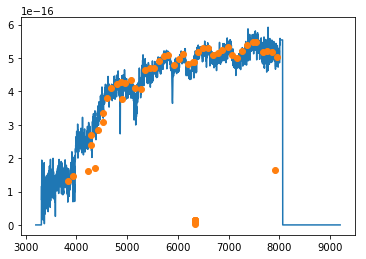

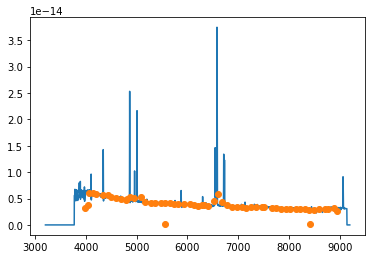

Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; t

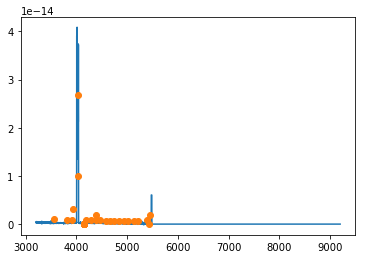

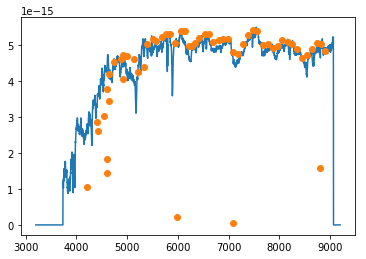

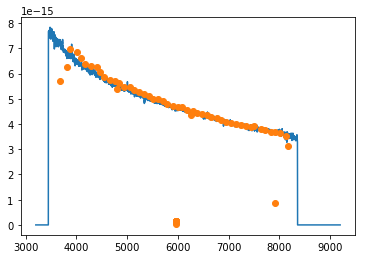

ValueError: Integrated flux is <= 0

In [5]:
# JPAS -------------------------------------------------------------------------------------------------------------
all_jpas = []
for each_spectrum in specs_list:
    # Transforming the specs from f_lambda to f_nu -----------------------------------------------------------------
    wavelength = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[0])
    f_lambda   = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[1])
    # Simulating the photometry for each J-PAS band ----------------------------------------------------------------
    filter_name     = []
    photometry      = []
    photometry_flam = []
    lambda_eff      = []
    for jpas_filters in jpas_filters_list:
        filter_name_i          = jpas_filters.split('.')[0]
        filter_name.append(filter_name_i)
        jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))        
#         print jpas_filter_bandpass.throughput
        sdss_spectrum        = s.FileSpectrum(os.path.join(test_specs, each_spectrum))
        photometry_i         = s.Observation(sdss_spectrum, jpas_filter_bandpass, binset=np.arange(3000, 11000), 
                                             force='extrap')
        photometry.append(photometry_i.effstim('abmag'))
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)
        photometry_flam_i = photometry_i.effstim('flam')
        photometry_flam.append(photometry_flam_i)

    filter_name       = np.array(filter_name)
    photometry        = np.array(photometry)
    lambda_eff        = np.array(lambda_eff) 
    photometry_flam   = np.array(photometry_flam)
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))
    
    numerator_sum   = 0
    denominator_sum = 0
    for j in range(lambda_eff.size):
        index = np.abs(lambda_eff[j] - wavelength).argmin()
        numerator_sum   = numerator_sum + (photometry_flam[j] * f_lambda[index])
        denominator_sum = denominator_sum + (photometry_flam[j] ** 2.)
        correction_factor = (numerator_sum / denominator_sum)
    photometry_flam = photometry_flam * correction_factor
    
    plt.plot(wavelength, f_lambda, '-')
    plt.plot(lambda_eff, photometry_flam, 'o')
    plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS.png'), dpi = 100)
    plt.show()
    
    galaxy_simulation_abmag = np.vstack((filter_name, photometry))
    galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
    galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_abmag.csv'), 
                                   sep=',', header=None, index=False)
    galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
    galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
    galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_fnu.csv'), 
                                 sep=',', header=None, index=False)
    
